In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import datetime

from pandas_datareader import data as web

from qiskit_finance.data_providers import YahooDataProvider

plt.style.use('dark_background')

In [3]:
def get_stock_dataframe(ticker, density=False):
    
    start = datetime.datetime(2020, 3, 19)
    end = datetime.datetime(2021, 2, 20)
    
    ticker_close_data = web.DataReader(ticker, 'yahoo', start, end)['Close']
    
    return ticker_close_data


def plot_stock(data, ticker, density):
    
    column = data[ticker]
    
    rmean = column.mean()
    rstd = column.std()
    
    column.hist(bins=40, histtype="stepfilled", alpha=0.5, density=density, figsize=(8, 4))
    
    if density is True:
        
        x = np.linspace(rmean - 4 * rstd, 
                        rmean + 4 * rstd, 200)
        
        distribution = scipy.stats.norm.pdf(x, rmean, rstd)
        
        plt.plot(x, distribution, "r")
        
        ylabel = "Probability"
    else:
        ylabel = "Frequency"
        
    plt.gca().set(title=ylabel + ' Histogram for ' + ticker, ylabel=ylabel, xlabel='Price (USD)')
    plt.axvline(rmean, color='#fdb462', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(rmean + rstd, color='#fdb462', linestyle='dashed', linewidth=2, label='σ')
    plt.axvline(rmean - rstd, color='#fdb462', linestyle='dashed', linewidth=2, label='-σ')
    plt.axvline(rmean + 2 * rstd, color='#fdb462', linestyle='dashed', linewidth=2, label='2σ')
    plt.axvline(rmean - 2 * rstd, color='#fdb462', linestyle='dashed', linewidth=2, label='-2σ')
    plt.show()

In [4]:
data=get_stock_dataframe(['NFLX', 'AAPL', 'META', 'GOOG'])

data.head()

Symbols,NFLX,AAPL,META,GOOG
Date,,,,
2020-03-19,332.029999,61.195000,153.130005,55.764500
2020-03-20,332.829987,57.310001,149.729996,53.616001
2020-03-23,360.269989,56.092499,148.100006,52.831001
2020-03-24,357.320007,61.720001,160.979996,56.723000
2020-03-25,342.390015,61.380001,156.210007,55.124500


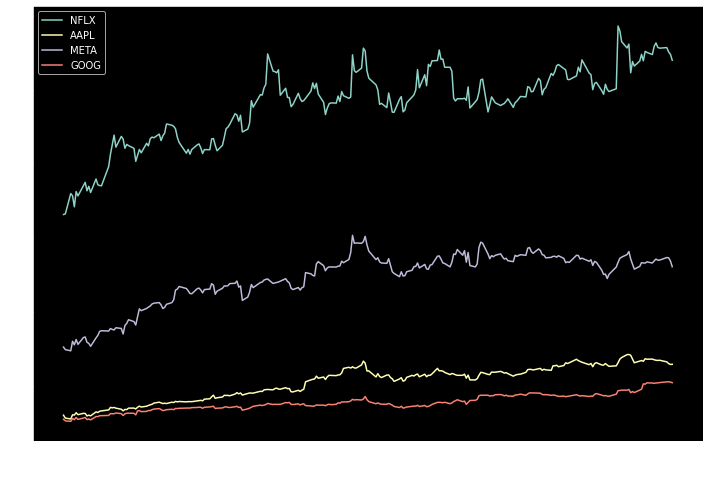

In [5]:
plt.figure(figsize=(12, 8))

for column in data.columns:    
    plt.plot(data[column], label=column)

plt.legend()
plt.xticks(rotation=90)
plt.show()

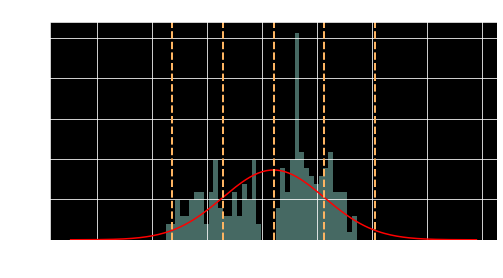

In [6]:
plot_stock(data, ticker='AAPL', density=True)

In [7]:
def monte_carlo(tickers, df, n):
    
    dailyReturns = df.pct_change()
    annualReturns = dailyReturns.mean() * 253
    dailyCov = dailyReturns.cov()
    annualCov = dailyCov * 253
    np.random.seed(42)

    portfolioReturns = []
    portfolioRisk = []
    stockWeights = []
    
    for portf in range(n):

        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)

        returns = np.dot(weights, annualReturns)
        risk = np.sqrt(np.dot(weights.T, np.dot(annualCov, weights)))

        portfolioReturns.append(returns)
        portfolioRisk.append(risk)
        stockWeights.append(weights)

        portfolio = {'Returns': portfolioReturns, 'Risk': portfolioRisk}
        
        for idx, tic in enumerate(tickers):
            portfolio[tic+'_Weight'] = [Weight[idx] for Weight in stockWeights]
            
    pdf = pd.DataFrame(portfolio)
    data=pd.concat([pdf['Returns'], pdf['Risk']], axis=1)
    data['Sharpe'] = pdf['Returns']/pdf['Risk']
    
    return data


def max_sharpe(data):
    
    print('Max sharpe ratio in the array: {}'.format(data['Sharpe'].max()))
    print('Its location in the array: {}'.format(data['Sharpe'].argmax()))
    
    max_sr_ret = data['Returns'][data['Sharpe'].argmax()]
    max_sr_vol = data['Risk'][data['Sharpe'].argmax()]
    
    return {'return': max_sr_ret, 'volatility': max_sr_vol}


def plot_efficiency(data, sharpe):
    
    plt.figure(figsize=(12,8))
    plt.title('Markowitz portfolio (Monte-Carlo)')
    plt.scatter(data['Risk'], data['Returns'], c=data['Sharpe'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(sharpe['volatility'], sharpe['return'], c='red', s=50)
    plt.xlabel('Volatility - Standard deviation')
    plt.ylabel('Return')
    plt.show()

In [8]:
n = 1000

tickers = ['NFLX', 'AAPL', 'META', 'GOOG']

mc_data = monte_carlo(tickers, data, n)
sharpe = max_sharpe(mc_data)

Max sharpe ratio in the array: 2.5196748736791803
Its location in the array: 117


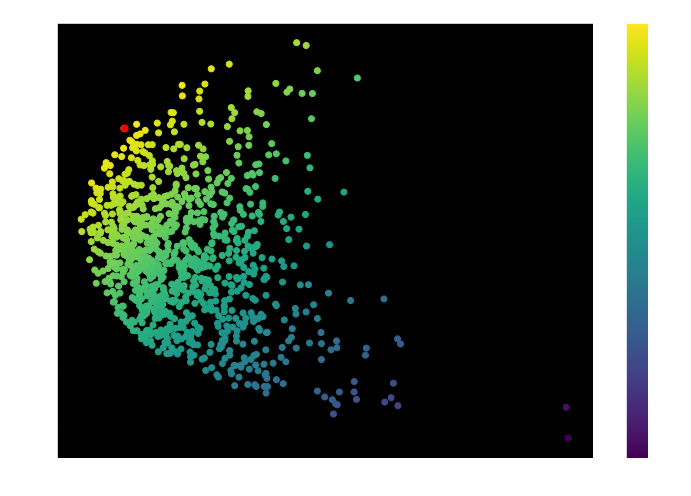

In [9]:
plot_efficiency(mc_data, sharpe)

## Calculate means vector, similarity and covariance matrices

In [57]:
SYMBOLS_COUNT = 8

sp_500 = pd.read_excel('simulated_prices/sp_500.xlsx')

symbols = sp_500['Symbol'].to_list()[:SYMBOLS_COUNT]

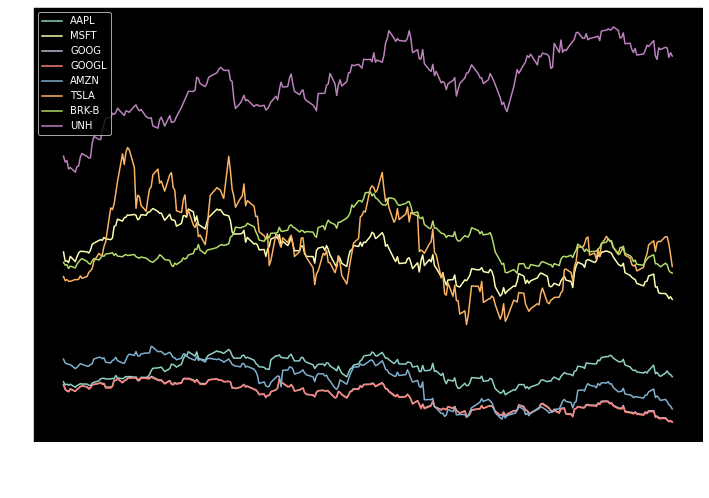

In [59]:
tickers = ['NFLX', 'AAPL', 'META', 'GOOG']
tickers = ['NFLX', 'AAPL', 'META', 'GOOG', 'TSLA', 'AMZN', 'MSFT', 'NVDA']

tickers = symbols

num_assets = len(tickers)

data = YahooDataProvider(
         tickers=tickers,
         start=datetime.datetime(2021, 9, 26),
         end=datetime.datetime(2022, 9, 26))

data.run()
plt.figure(figsize=(12,8))
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()

Means:
 [158.18459645 289.82696819 128.305008   127.854263   145.30262966
 299.73867196 302.0543022  485.32964662]
A time-series similarity measure:


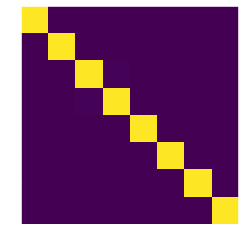

A covariance matrix:


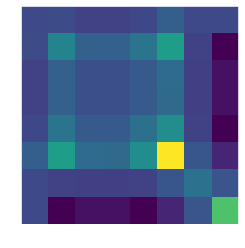

Sigma


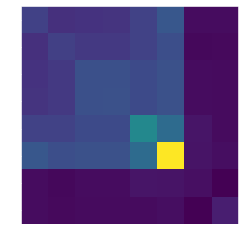

Mu: [ 3.56970864e-04 -6.21611789e-04 -1.18493028e-03 -1.18806299e-03
 -1.20398131e-03  9.87870044e-04 -9.54366178e-05  1.11377263e-03]


In [60]:
means = data.get_mean_vector()
rho = data.get_similarity_matrix()
cov = data.get_covariance_matrix()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

print("Means:\n", means)

print("A time-series similarity measure:")
plt.imshow(rho)
plt.show()

print("A covariance matrix:")
plt.imshow(cov)
plt.show()

print("Sigma")
plt.imshow(sigma, interpolation='nearest')
plt.show()

print("Mu:", mu)

In [61]:
import itertools

def get_binary_permutations(num_assets):
    return [list(seq) for seq in itertools.product([0, 1], repeat=num_assets)]

perms = get_binary_permutations(num_assets)

In [62]:
def get_risks(portfolios, sigma):
    
    risks = []
    
    for portfolio in portfolios:
        
        x_t = np.array(portfolio)
        x = np.array([portfolio]).T
        
        risk = x_t.dot(sigma).dot(x)
        
        risks.append(risk[0])
        
    return risks


def get_returns(portfolios, mu):
    
    returns = []
    
    for portfolio in portfolios:
        
        x = np.array([portfolio]).T
        
        return_value = mu.dot(x)   
        
        returns.append(return_value[0])
        
    return returns


def get_sharpe(portfolios, sigma, mu):
    
    risks = get_risks(portfolios, sigma)
    returns = get_returns(portfolios, mu)
    
    sharpe = np.array(returns) / np.array(risks)
    
    return sharpe

In [63]:
risks = get_risks(perms, sigma)
returns = get_returns(perms, mu)

In [64]:
pdf = pd.DataFrame({'Risk': risks, 'Return': returns})
pdf['Sharpe'] = pdf['Return'] / pdf['Risk']

In [65]:
def quantum_portfolio_plot(pdf):
    plt.figure(figsize=(12,8))
    plt.title('Markowitz portfolio (Combinations of all portfolio selections)')
    plt.scatter(pdf['Risk'], pdf['Return'], c=pdf['Sharpe'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(sharpe['volatility'], sharpe['return'], c='red', s=50, marker=5)
    
    # for x, y, perm in zip(pdf['Risk'], pdf['Returns'], perms):
    #     plt.annotate(perm,
    #                  (x,y), # this is the point to label
    #                  textcoords="offset points", # how to position the text
    #                  xytext=(-5,3), # distance from text to points (x,y)
    #                  ha='center') # horizontal alignment can be left, right or center     
    
    plt.xlabel('Volatility - standard deviation')
    plt.ylabel('Return')
    plt.show()
    
    
def max_sharpe(data):
    
    print('Max sharpe ratio in the array: {}'.format(data['Sharpe'].max()))
    print('Its location in the array: {}'.format(data['Sharpe'].argmax()))
    max_sr_ret = data['Return'][data['Sharpe'].argmax()]
    max_sr_vol = data['Risk'][data['Sharpe'].argmax()]
    return {'return': max_sr_ret, 'volatility': max_sr_vol}

Max sharpe ratio in the array: 4.85126002218912
Its location in the array: 1


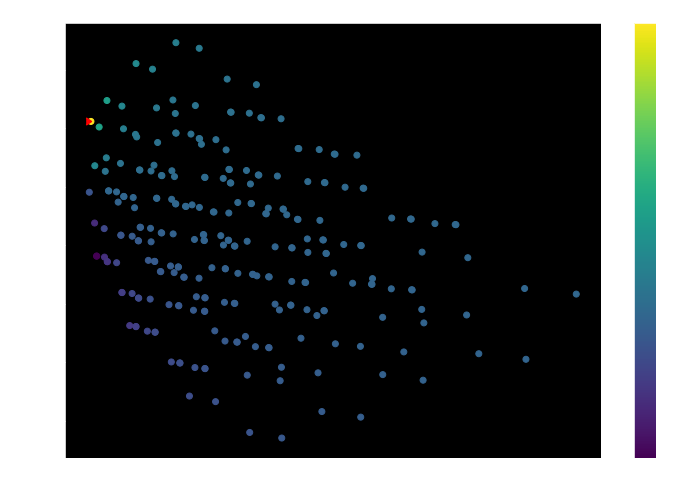

In [66]:
sharpe = max_sharpe(pdf)

quantum_portfolio_plot(pdf)

In [67]:
pdf

,Risk,Return,Sharpe
0,0.000000,0.000000,NaN
1,0.000230,0.001114,4.851260
2,0.000159,-0.000095,-0.600884
3,0.000584,0.001018,1.743168
4,0.001635,0.000988,0.604360
...,...,...,...
251,0.013737,-0.002823,-0.205516
252,0.016976,-0.002854,-0.168110
253,0.018953,-0.001740,-0.091806
254,0.019011,-0.002949,-0.155134


In [52]:
# Export dataset

sharpe_dataset = pd.DataFrame(perms)

sharpe_dataset['sharpe'] = pdf.Sharpe

sharpe_dataset.fillna(value=0, inplace=True)

# sharpe_dataset.to_csv('sharpe_27.csv', index=False)

sharpe_dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,sharpe
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.651689
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.046317
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,-0.863664
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-2.494129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,-0.068568
65532,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,-0.110672
65533,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,-0.110214
65534,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,-0.105896


In [53]:
sorted_sharpe_dataset = sharpe_dataset.sort_values('sharpe', ascending=False)

sorted_sharpe_dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,sharpe
256,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4.851260
64,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4.129498
320,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,3.594081
192,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3.519249
66,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3.006348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,-2.367242
4096,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-2.482455
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-2.494129
8192,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-2.498242
